Implémentation du papier de recherche "(S)GD over Diagonal Linear Networks:
Implicit Bias, Large Stepsizes and Edge of Stability"

In [1]:
import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Données synthétiques

On génère les données synthétiques pour avoir un $\beta_{sparse}$ à support non nul sur k composantes et nul sur le reste$

In [2]:
def generate_data(n, d, k, sigma=0.0):
    X = torch.randn(n, d, device=device)
    
    w_star = torch.zeros(d, 1, device=device)
    indices = torch.randperm(d, device=device)[:k]
    w_star[indices] = torch.randn(k, 1, device=device) 
    
    y = X @ w_star + sigma * torch.randn(n, 1, device=device)
    
    return X, y, w_star

n, d, k = 40, 100, 3
X, y, w_star = generate_data(n, d, k)

train_dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialisation de la classe du Diagonal Linear Net

In [8]:
class DLN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, alpha = 0.1, uniform = True):
        super(DLN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.alpha = alpha
        self.uniform = uniform

        self._initialize_weights()

    def _initialize_weights(self):

        nn.init.zeros_(self.fc1.weight)
        nn.init.zeros_(self.fc2.weight)
        if self.fc1.bias is not None: nn.init.zeros_(self.fc1.bias)
        if self.fc2.bias is not None: nn.init.zeros_(self.fc2.bias)

        with torch.no_grad():
            min_dim = min(self.fc1.in_features, self.fc1.out_features)

            if self.uniform:
                vals = torch.full((min_dim,), self.alpha, device=self.fc1.weight.device)
            
            else:
                vals = torch.rand(min_dim, device=self.fc1.weight.device) * 2 * self.alpha
            
            indices = torch.arange(min_dim, device=self.fc1.weight.device)
            self.fc1.weight[indices, indices] = vals
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# Fonction d'entrainement du DLN

In [4]:
def train_dln(model, X, y, lr, epochs, mode='gd', batch_size=None, threshold=1e-5):
    criterion = nn.MSELoss()
    
    if mode == 'sgd' and batch_size is None:
        batch_size = 1
        
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    mask = torch.eye(model.fc1.weight.shape[0], device=device)
    
    if mode == 'gd':
        data_loader = [(X, y)] 
    else:
        dataset = torch.utils.data.TensorDataset(X, y)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
    for epoch in range(epochs):
        for batch_X, batch_y in data_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            
            
            with torch.no_grad():
                model.fc1.weight.grad *= mask
            
            optimizer.step()
            
        if loss.item() < threshold:
            break
            
    return model

# Experimentations

## Exp 1

La première expérimentation correspond à la figure 1. On va augmenter le stepsize jusqu'au Edge of Stability

In [5]:
n = 20
d = 30
k = 3
alpha = 0.1

X, y, w_star = generate_data(n, d, k)

stepsizes = np.logspace(-2, 0.5, 20)

test_losses_gd = []
test_losses_sgd = []

print("Lancement de l'expérience")

for lr in stepsizes:
    model_gd = DLN(d, 1, d, alpha=alpha, uniform=True).to(device)
    train_dln(model_gd, X, y, lr=lr, epochs=5000, mode='gd', threshold=1e-5)
    
    with torch.no_grad():
        w1 = model_gd.fc1.weight.diag()
        w2 = model_gd.fc2.weight.flatten()
        beta_gd = (w1 * w2).unsqueeze(1)
        error_gd = torch.norm(beta_gd - w_star)**2
        test_losses_gd.append(error_gd.item())

    model_sgd = DLN(d, 1, d, alpha=alpha, uniform=True).to(device)
    train_dln(model_sgd, X, y, lr=lr, epochs=5000, mode='sgd', batch_size=1, threshold=1e-5)
    
    with torch.no_grad():
        w1 = model_sgd.fc1.weight.diag()
        w2 = model_sgd.fc2.weight.flatten()
        beta_sgd = (w1 * w2).unsqueeze(1)
        error_sgd = torch.norm(beta_sgd - w_star)**2
        test_losses_sgd.append(error_sgd.item())


Lancement de l'expérience


KeyboardInterrupt: 

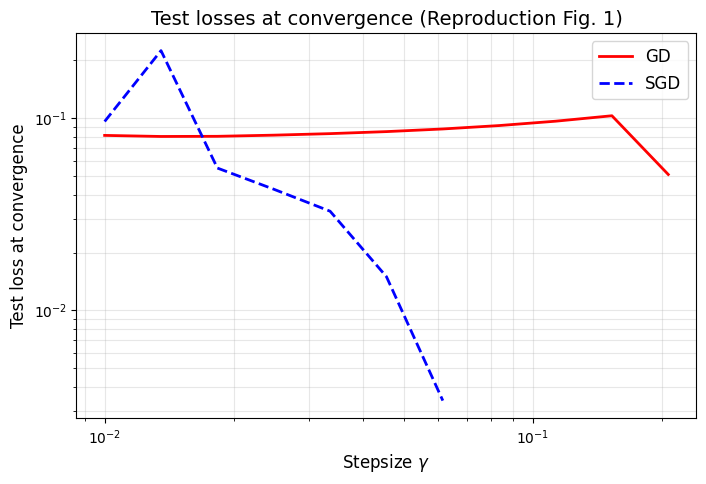

In [ ]:
plt.figure(figsize=(8, 5))
plt.loglog(stepsizes, test_losses_gd, 'r-', label='GD', linewidth=2)
plt.loglog(stepsizes, test_losses_sgd, 'b--', label='SGD', linewidth=2)

plt.xlabel('Stepsize $\gamma$', fontsize=12)
plt.ylabel('Test loss at convergence', fontsize=12)
plt.title('Test losses at convergence (Reproduction Fig. 1)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()

## Exp 2

On trace le gain en fonction du stepsize

In [5]:
n = 20
d = 30
k = 3
alpha = 0.1

X, y, w_star = generate_data(n, d, k)

stepsizes = np.logspace(-2, 0.5, 20)

Starting Gain Scale Experiment...


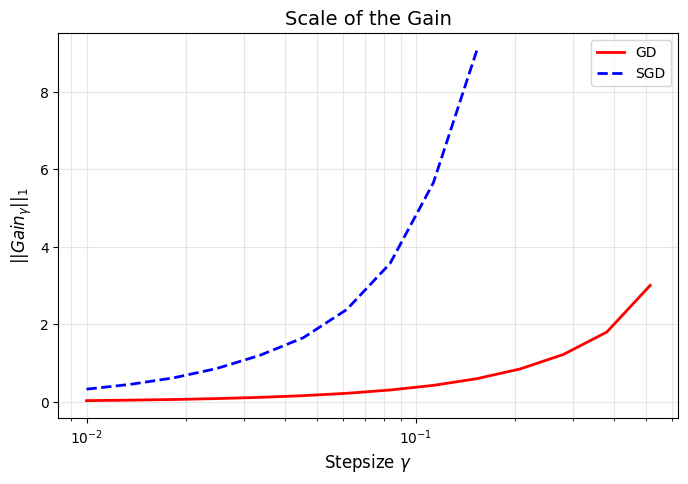

In [7]:
def compute_gain_scale(model, X, y, lr, epochs, mode='gd', batch_size=1, threshold=1e-5):
    criterion = nn.MSELoss()
    total_gain = torch.zeros(d, device=device)
    
    if mode == 'gd':
        data_loader = [(X, y)]
    else:
        dataset = torch.utils.data.TensorDataset(X, y)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
    mask = torch.eye(d, device=device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in data_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            
            # Loss for DLN is L(u \odot v)
            loss = criterion(output, batch_y)
            loss.backward()

            # The gain depends on the gradient of the loss w.r.t the prediction parameter beta
            # For quadratic loss: grad_beta = (1/|B|) * X_B^T * (X_B * beta - y_B)
            with torch.no_grad():
                # Extract beta from weights
                w1 = model.fc1.weight.diag()
                w2 = model.fc2.weight.flatten()
                beta = w1 * w2
                
                # Compute gradient w.r.t beta for the current batch
                # Note: 1/n factor for MSE
                grad_beta = (1.0 / batch_X.shape[0]) * (batch_X.t() @ (batch_X @ beta.unsqueeze(1) - batch_y)).flatten()
                
                # q(x) = -0.5 * ln((1-x^2)^2)
                x = lr * grad_beta
                # Clamp to avoid log(0) at divergence threshold
                q_val = -0.5 * torch.log((1 - x**2)**2 + 1e-10)
                total_gain += q_val
                
                # Apply mask to keep network diagonal
                model.fc1.weight.grad *= mask
            
            optimizer.step()
            epoch_loss += loss.item()
            
        if (epoch_loss / len(data_loader)) < threshold:
            break
            
    return torch.norm(total_gain, p=1).item()

# Experiment parameters
gain_scales_gd = []
gain_scales_sgd = []

print("Starting Gain Scale Experiment...")
for lr in stepsizes:
    # Scale for GD
    model_gd = DLN(d, 1, d, alpha=alpha).to(device)
    gain_gd = compute_gain_scale(model_gd, X, y, lr, epochs=5000, mode='gd')
    gain_scales_gd.append(gain_gd)
    
    # Scale for SGD
    model_sgd = DLN(d, 1, d, alpha=alpha).to(device)
    gain_sgd = compute_gain_scale(model_sgd, X, y, lr, epochs=5000, mode='sgd', batch_size=1)
    gain_scales_sgd.append(gain_sgd)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(stepsizes, gain_scales_gd, 'r-', label='GD', linewidth=2)
plt.plot(stepsizes, gain_scales_sgd, 'b--', label='SGD', linewidth=2)

plt.xscale('log')
plt.xlabel('Stepsize $\gamma$', fontsize=12)
plt.ylabel('$||Gain_{\gamma}||_1$', fontsize=12)
plt.title('Scale of the Gain', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()

Starting 200 runs for Shape of Gain...


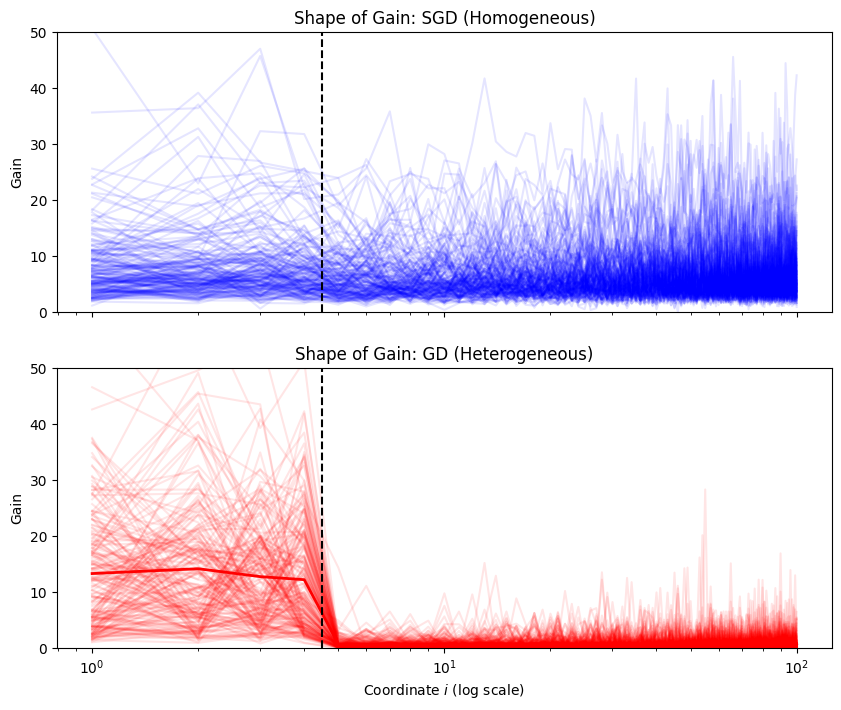

In [29]:
def run_shape_experiment(num_runs, n=50, d=100, s=4, lr_gd=0.8, lr_sgd=0.15, epochs=5000):
    all_gains_gd = []
    all_gains_sgd = []
    
    # Define a fixed support for beta_star (e.g., first s coordinates)
    # This allows us to align the gain plots later
    support = torch.arange(s)
    w_star_fixed = torch.zeros(d, 1, device=device)
    w_star_fixed[support] = 1.0 #torch.randn(s, 1, device=device).abs() 

    print(f"Starting {num_runs} runs for Shape of Gain...")

    for run in range(num_runs):
        # Generate new feature matrix X for each run
        X_run = torch.randn(n, d, device=device)
        y_run = X_run @ w_star_fixed
        
        # --- GD RUN ---
        model_gd = DLN(d, 1, d, alpha=alpha).to(device)
        gain_gd = torch.zeros(d, device=device)
        optimizer_gd = optim.SGD(model_gd.parameters(), lr=lr_gd)
        
        for _ in range(epochs):
            optimizer_gd.zero_grad()
            beta = model_gd.fc1.weight.diag() * model_gd.fc2.weight.flatten()
            loss = 0.5 * torch.mean((X_run @ beta.unsqueeze(1) - y_run)**2)
            loss.backward()
            
            with torch.no_grad():
                grad_beta = (1.0/n) * (X_run.t() @ (X_run @ beta.unsqueeze(1) - y_run)).flatten()
                gain_gd += -0.5 * torch.log((1 - (lr_gd * grad_beta)**2)**2 + 1e-10)
                model_gd.fc1.weight.grad *= torch.eye(d, device=device)
            optimizer_gd.step()
            if loss.item() < 1e-5: break
        all_gains_gd.append(gain_gd.cpu().numpy())

        # --- SGD RUN (batch_size=1) ---
        model_sgd = DLN(d, 1, d, alpha=alpha).to(device)
        gain_sgd = torch.zeros(d, device=device)
        optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=lr_sgd)
        
        for _ in range(epochs):
            idx = torch.randint(0, n, (1,))
            xi, yi = X_run[idx], y_run[idx]
            
            optimizer_sgd.zero_grad()
            beta = model_sgd.fc1.weight.diag() * model_sgd.fc2.weight.flatten()
            loss = 0.5 * (xi @ beta.unsqueeze(1) - yi)**2
            loss.backward()
            
            with torch.no_grad():
                grad_beta_i = (xi.t() @ (xi @ beta.unsqueeze(1) - yi)).flatten()
                gain_sgd += -0.5 * torch.log((1 - (lr_sgd * grad_beta_i)**2)**2 + 1e-10)
                model_sgd.fc1.weight.grad *= torch.eye(d, device=device)
            optimizer_sgd.step()
            if torch.mean((X_run @ beta.unsqueeze(1) - y_run)**2).item() < 1e-5: break
        all_gains_sgd.append(gain_sgd.cpu().numpy())

    return np.array(all_gains_gd), np.array(all_gains_sgd), support.numpy()


n_right = 50
d_right = 100
s_right = 4

# Run the experiment with explicit dimensions
gains_gd, gains_sgd, support_indices = run_shape_experiment(
    num_runs=200, 
    n=n_right, 
    d=d_right, 
    s=s_right, 
    lr_gd=0.95, 
    lr_sgd=0.15
)

# Plotting with the correct dimension d_right
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
coords = np.arange(1, d_right + 1) 

# SGD Plot
for g in gains_sgd: 
    ax1.plot(coords, g, color='blue', alpha=0.1)
ax1.plot(coords, gains_sgd.mean(axis=0), color='blue', linewidth=3, label='Averaged SGD')
ax1.set_title("Shape of Gain: SGD (Homogeneous)")
ax1.set_ylabel("Gain")
ax1.axvline(x=s_right + 0.5, color='black', linestyle='--') # Vertical line after the support
ax1.set_ylim(0, 50)

# GD Plot
for g in gains_gd: 
    ax2.plot(coords, g, color='red', alpha=0.1)
ax2.plot(coords, gains_gd.mean(axis=0), color='red', linewidth=2, label='Averaged GD')
ax2.set_title("Shape of Gain: GD (Heterogeneous)")
ax2.set_xlabel("Coordinate $i$ (log scale)")
ax2.set_ylabel("Gain")
ax2.axvline(x=s_right + 0.5, color='black', linestyle='--')
ax2.set_ylim(0, 50)

plt.xscale('log')
plt.show()